# Kapitel 5: Annotation

Das Notebook ergänzt Kapitel 5 'Annotation'.

# Import

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import re
from resources_geschichtslyrik import *

from nltk import agreement
from nltk.metrics.distance import masi_distance
from nltk.metrics.distance import interval_distance
import krippendorff

In [2]:
meta = pd.read_json(r"../resources/meta.json")

In [3]:
annotations = pd.read_csv(r"../resources/more/annotations_iaa.csv")

In [4]:
annotations = annotations.rename(columns={'Annotator:in':'annotator'})
annotations['author_title'] = annotations['Autor'] + ' – ' + annotations['Titel']
annotations['annotator_author_title'] = annotations['annotator'] + ' – ' + annotations['author_title']
annotations = annotations.drop_duplicates(subset='annotator_author_title')

In [5]:
# annotations['(10) Wissen der Sprechinstanz'] = annotations['(10) Wissen der Sprechinstanz'].replace({
#     float('NaN') : 0
# })

In [6]:
# annotations['(23) Bewertung Stoffgebiet'] = annotations['(23) Bewertung Stoffgebiet'].replace({
#     'neutral' : 0,
#     'positiv' : 1,
#     'negativ' : -1,
#     'ambivalent' : 0,
# })
# 
# annotations['(25) Bewertung Entitäten'] = annotations['(25) Bewertung Entitäten'].replace({
#     'neutral' : 0,
#     'positiv' : 1,
#     'negativ' : -1,
#     'ambivalent' : 0,
# })

In [7]:
ak_texts = annotations.query("annotator == 'ak'")['author_title'].tolist()
ek_texts = annotations.query("annotator == 'ek'")['author_title'].tolist()
mk_texts = annotations.query("annotator == 'mk'")['author_title'].tolist()

ak_ek_texts = [x for x in ak_texts if x in ek_texts]
ak_mk_texts = [x for x in ak_texts if x in mk_texts]
ek_mk_texts = [x for x in ek_texts if x in mk_texts]
ak_ek_mk_texts = [x for x in ak_texts if x in ek_texts and x in mk_texts]

print(f"Texte SHK1 <> SHK2              : {len(ak_ek_texts)}")
print(f"Texte SHK1 <> Verfasser         : {len(ak_mk_texts)}")
print(f"Texte SHK2 <> Verfasser         : {len(ek_mk_texts)}")
print(f"Texte SHK1 <> SHK2 <> Verfasser : {len(ak_ek_mk_texts)}")

Texte SHK1 <> SHK2              : 30
Texte SHK1 <> Verfasser         : 30
Texte SHK2 <> Verfasser         : 30
Texte SHK1 <> SHK2 <> Verfasser : 30


# Anzahl Annotationen

In [8]:
# Annotierte Texte (absolut)
meta.query("annotated").drop_duplicates(subset='author_title').shape[0]

3727

In [9]:
# Annotierte geschichtslyrische Texte Anthologien (Anteil)
meta_anth = (
    meta
    .query("corpus=='anth'")
    .query("geschichtslyrik==1")
    .query("1850 <= year <= 1918")
    .drop_duplicates(subset='author_title')
)

meta_anth.query("annotated").shape[0]/meta_anth.shape[0]

1.0

In [10]:
# Annotierte Texte Ergänzungskorpors 'Kanonisierte Moderne' (Anteil)
modcanon_authors = ['Hofmannsthal, Hugo von', 'Rilke, Rainer Maria', 'George, Stefan', 'Heym, Georg']

meta_modcanon = (
    meta
    .query("author in @modcanon_authors")
    .query("1850 <= year <= 1918")
    .drop_duplicates(subset='author_title')
)

meta_modcanon.query("annotated").shape[0]/meta_modcanon.shape[0]

1.0

In [11]:
# Annotierte Texte Ergänzungskorpors 'Münchhausen-Kreis' (Anteil)
muench_authors = ['Münchhausen, Börries von', 'Miegel, Agnes', 'Strauß und Torney, Lulu von']

meta_muench = (
    meta
    .query("author in @muench_authors")
    .query("1850 <= year <= 1918")
    .drop_duplicates(subset='author_title')
)

meta_muench.query("annotated").shape[0]/meta_muench.shape[0]

1.0

# IAA berechnen

### Demo: Ordinal/Interval

In [12]:
rel_data = [
    ["annotator A", "Doc1", 1],
    ["annotator A", "Doc2", 2],
    ["annotator A", "Doc3", 5],
    
    ["annotator B", "Doc1", 2],
    ["annotator B", "Doc2", 2],
    ["annotator B", "Doc3", 3],
    
    ["annotator C", "Doc1", 2],
    ["annotator C", "Doc2", 2],
    ["annotator C", "Doc3", 2],
]

task = agreement.AnnotationTask(distance=interval_distance)
task.load_array(rel_data)

print("nltk:")
print(task.alpha())

nltk:
0.288888888888889


In [13]:
print("\nkrippendorff:")
print(krippendorff.alpha(
    [
        [1, 2, 5], 
        [2, 2, 3], 
        [2, 2, 2], 
    ], 
    level_of_measurement = 'interval')
)


krippendorff:
0.28888888888888886


### Demo: Nominal

In [14]:
rel_data = [
    ["annotator A", "Doc1", frozenset({"Naturlyrik"})], # mit nltk mehrere Label möglich
    ["annotator A", "Doc2", frozenset({"Naturlyrik"})],
    ["annotator A", "Doc3", frozenset({"Religiöse Lyrik"})],
    
    ["annotator B", "Doc1", frozenset({"Religiöse Lyrik"})],
    ["annotator B", "Doc2", frozenset({"Naturlyrik"})],
    ["annotator B", "Doc3", frozenset({"Religiöse Lyrik"})],
]

task = agreement.AnnotationTask(distance=masi_distance)
task.load_array(rel_data)

print("nltk:")
print(task.alpha())

nltk:
0.4444444444444444


In [15]:
print("\nkrippendorff:")
print(krippendorff.alpha(
    [
        ['Naturlyrik', 'Naturlyrik', 'Religiöse Lyrik'], 
        ['Religiöse Lyrik', 'Naturlyrik', 'Religiöse Lyrik'], 
    ], 
    level_of_measurement = 'nominal')
)


krippendorff:
0.4444444444444444


In [16]:
iaa_overview = pd.DataFrame()

In [17]:
# Annotationen für Texte, die von lediglich einer Person
# annotiert wurden, aus rel_data entfernen

def clear_rel_data(data):
    docs = [x[1] for x in data]
    single_docs = [x for x in docs if docs.count(x) == 1]

    for i, item in enumerate(data):
        if item[1] in single_docs:
            data.pop(i)
    
    return data

### Berechnung: Ordinal/Interval

In [18]:
interval_categories = [
    '(02) Empirische Ausrichtung',
    '(03) Geschichtstheoretische Ausrichtung',
    '(05) Markiertheit der Sprechinstanz',
    '(06) Zeitliche Position der Sprechinstanz',
    '(09) Konkretheit', # interval
    '(11) Zeitdominanz', # interval
    '(12) Anzahl Zeitebenen', # interval
    '(13) Fixierbarkeit der dominanten Zeitebene',
    '(14) Beginn der dominanten Zeitebene', # interval
    '(15) Ende der dominanten Zeitebene', # interval
    '(16) Anachronismen',
    '(17) Gegenwartsbezug',
    '(26) Nationalismus',
    '(27) Heroismus',
    '(28) Religiosität',
    '(33) Überlieferung',
    '(35) Geschichtsauffassungen',
    '(38) Reim', # interval
    '(39) Metrum', # interval
    '(40) Verfremdende Sprache' # interval
]

In [19]:
for category in interval_categories:
    annotators = ['ak', 'ek', 'mk']

    rel_data = []
    for title in annotations['author_title'].unique():
        annotation_title = annotations.query("author_title == @title")

        for annotator in annotators:
            annotation_title_annotator = annotation_title.query("annotator == @annotator")
            if annotation_title_annotator.shape[0] > 0:
                annos = annotation_title_annotator[category].tolist()[0]
                if pd.notna(annos):
                    rel_data.append([annotator, title, annos])

    for annotator_set in [['ak', 'ek'], ['ak', 'mk'], ['ek', 'mk'], ['ak', 'ek', 'mk']]:
        label = ('_').join(annotator_set)
        rel_data_set = [x for x in rel_data if x[0] in annotator_set]

        if len(rel_data_set) > 0:
            rel_data_set = clear_rel_data(rel_data_set)
            task = agreement.AnnotationTask(distance=interval_distance)
            task.load_array(rel_data_set)
            agreement_nltk = task.alpha()
            iaa_overview.at[category, label] = agreement_nltk

### Berechnung: Nominal/Multi-Label

In [20]:
nominal_categories = [
    '(04) Gattung',
    '(08) Tempora',
    '(07) Sprechakte',
    '(10) Wissen der Sprechinstanz', # (NaN-Problem)
    '(18) Großraum',
    '(19) Mittelraum',
    '(20) Kleinraum',
    '(21) Inhaltstyp',
    '(22) Stoffgebiet',
    '(24) Entitäten',
    '(29) Geschichtsmarker Person',
    '(30) Geschichtsmarker Zeit',
    '(31) Geschichtsmarker Ort',
    '(32) Geschichtsmarker Objekt',
    '(34) Bewertung Überlieferung',
    '(36) Bewertung Geschichtsauffassungen',
    '(37) Verhältnis zum historischen Wissen'
]

In [21]:
for category in nominal_categories:
    annotators = ['ak', 'ek', 'mk']
    
    rel_data = []
    for title in annotations['author_title'].unique():
        annotation_title = annotations.query("author_title == @title")

        for annotator in annotators:
            annotation_title_annotator = annotation_title.query("annotator == @annotator")
            if annotation_title_annotator.shape[0] > 0:
                annos = annotation_title_annotator[category].astype(str).tolist()[0]
                annos = 'empty' if pd.isna(annos) else annos
                annos = annos.split(" + ")
                annos = [x.strip() if pd.notna(x) else x for x in annos]
                annos = frozenset(annos)
                rel_data.append([annotator, title, annos])

    for annotator_set in [['ak', 'ek'], ['ak', 'mk'], ['ek', 'mk'], ['ak', 'ek', 'mk']]:
        label = ('_').join(annotator_set)
        rel_data_set = [x for x in rel_data if x[0] in annotator_set]

        if len(rel_data_set) > 0:
            rel_data_set = clear_rel_data(rel_data_set)
            task = agreement.AnnotationTask(distance=masi_distance)
            task.load_array(rel_data_set)
            agreement_nltk = task.alpha()
            iaa_overview.at[category, label] = agreement_nltk

### Berechnung: Dependent

In [22]:
dependent_categories = [
    ('(22) Stoffgebiet', '(23) Bewertung Stoffgebiet'),
    ('(24) Entitäten', '(25) Bewertung Entitäten')
]

In [23]:
for category in dependent_categories:
    annotators = ['ak', 'ek', 'mk']
    
    rel_data = []
    for title in annotations['author_title'].unique():
        annotation_title = annotations.query("author_title == @title")

        for annotator in annotators:
            annotation_title_annotator = annotation_title.query("annotator == @annotator")
            if annotation_title_annotator.shape[0] > 0:
                annos_base = annotation_title_annotator[category[0]].tolist()[0]
                annos_base = annos_base.split(" + ")
                annos_base = [x.strip() if pd.notna(x) else x for x in annos_base]
                annos_base = [title + ' – ' + x for x in annos_base]
                annos_dependent = annotation_title_annotator[category[1]].tolist()[0]
                annos_dependent = annos_dependent.split(" + ")
                annos_dependent = [x.strip() if pd.notna(x) else x for x in annos_dependent]
                for anno_base, anno_dependent in zip(annos_base, annos_dependent):
                    anno_dependent = frozenset([anno_dependent])
                    rel_data.append([annotator, anno_base, anno_dependent])
                        
    for annotator_set in [['ak', 'ek'], ['ak', 'mk'], ['ek', 'mk'], ['ak', 'ek', 'mk']]:
        label = ('_').join(annotator_set)
        rel_data_set = [x for x in rel_data if x[0] in annotator_set]

        if len(rel_data_set) > 0:
            rel_data_set = clear_rel_data(rel_data_set)
            task = agreement.AnnotationTask(distance=masi_distance)
            task.load_array(rel_data_set)
            agreement_nltk = task.alpha()
            iaa_overview.at[category[1], label] = agreement_nltk

# Ergebnisse

In [24]:
iaa_overview = iaa_overview.sort_index()

In [25]:
round(iaa_overview[['ak_ek', 'ak_mk', 'ek_mk', 'ak_ek_mk']], 2)

,ak_ek,ak_mk,ek_mk,ak_ek_mk
(02) Empirische Ausrichtung,0.65,0.65,1.00,0.74
(03) Geschichtstheoretische Ausrichtung,1.00,0.65,0.65,0.74
(04) Gattung,0.65,0.70,0.79,0.71
(05) Markiertheit der Sprechinstanz,0.93,0.93,1.00,0.95
(06) Zeitliche Position der Sprechinstanz,0.56,0.67,0.69,0.65
(07) Sprechakte,0.19,0.48,0.42,0.36
(08) Tempora,0.83,0.61,0.78,0.74
(09) Konkretheit,0.69,0.39,0.41,0.51
(10) Wissen der Sprechinstanz,0.48,-0.02,-0.01,0.23
(11) Zeitdominanz,0.70,0.61,0.94,0.75


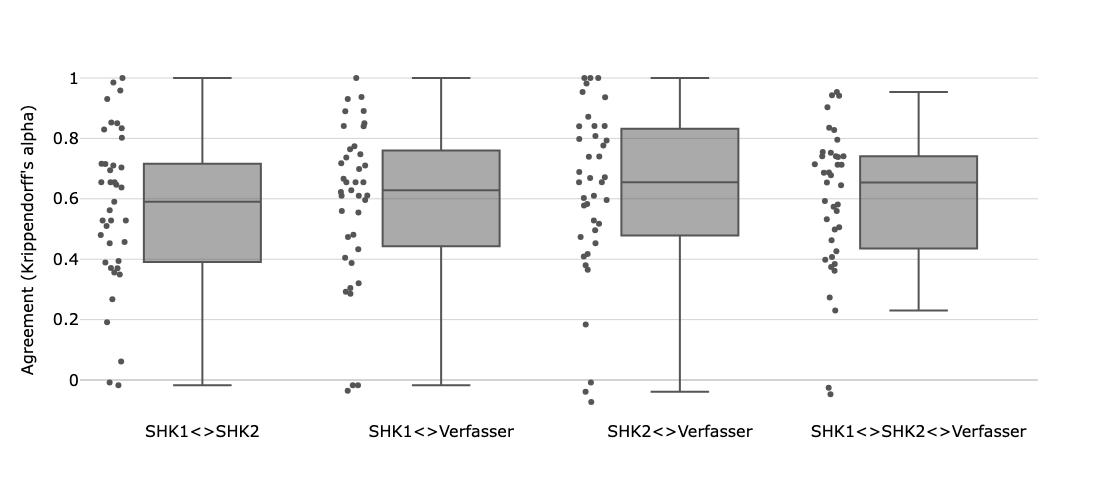

In [39]:
meta_plot = iaa_overview.copy()

meta_plot = iaa_overview.rename(columns={
    'ak_ek' : 'SHK1<>SHK2',
    'ak_mk' : 'SHK1<>Verfasser',
    'ek_mk' : 'SHK2<>Verfasser',
    'ak_ek_mk' : 'SHK1<>SHK2<>Verfasser'
})

fig = px.box(
    meta_plot,
    y = ['SHK1<>SHK2', 'SHK1<>Verfasser', 'SHK2<>Verfasser', 'SHK1<>SHK2<>Verfasser'],
    points = 'all',
    hover_data = [meta_plot.index],
    labels = {
        'value': "Agreement (Krippendorff's alpha)",
        'variable' : '',
    },
    # color_discrete_sequence=["grey"]
)

fig.update_layout(
    width = 1000, height = 500,
    xaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
    yaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
)
fig = update_fig_for_publication(fig, make_grey=True)
fig.write_image(f"plots/5 Inter-Annotator-Agreement.pdf")
fig.show()

In [27]:
print("mean agreement \n")
print(f"ak       : {iaa_overview[['ak_ek', 'ak_mk']].mean().mean()}")
print(f"ek       : {iaa_overview[['ak_ek', 'ek_mk']].mean().mean()}")
print(f"mk       : {iaa_overview[['ak_mk', 'ek_mk']].mean().mean()}")
print(f"ak_ek_mk : {iaa_overview[['ak_ek_mk']].mean().mean()}")

mean agreement 

ak       : 0.5802032986562972
ek       : 0.5964733198516784
mk       : 0.6076568107878321
ak_ek_mk : 0.596158308097664


In [28]:
print(iaa_overview.mean(axis = 1).sort_values())

(35) Geschichtsauffassungen                   -0.043029
(36) Bewertung Geschichtsauffassungen         -0.022467
(10) Wissen der Sprechinstanz                  0.171234
(23) Bewertung Stoffgebiet                     0.246283
(07) Sprechakte                                0.362992
(32) Geschichtsmarker Objekt                   0.371985
(34) Bewertung Überlieferung                   0.382236
(12) Anzahl Zeitebenen                         0.389374
(25) Bewertung Entitäten                       0.412151
(33) Überlieferung                             0.422036
(22) Stoffgebiet                               0.464739
(40) Verfremdende Sprache                      0.496703
(09) Konkretheit                               0.499221
(24) Entitäten                                 0.533228
(21) Inhaltstyp                                0.559930
(39) Metrum                                    0.565884
(37) Verhältnis zum historischen Wissen        0.574241
(38) Reim                                      0

In [29]:
for category in annotations.columns:
    if re.search(r'\([0-9]*\)', category):
        total_count = len(ak_ek_mk_texts)
        agreement_count = 0
        
        for text in ak_ek_mk_texts:
            meta_text = annotations.query("author_title == @text")
            if len(meta_text[category].unique()) == 1:
                agreement_count += 1

        iaa_overview.at[category, 'ak_ek_mk_percent'] = agreement_count/total_count

In [30]:
# percent agreement
iaa_overview.loc['(35) Geschichtsauffassungen', 'ak_ek_mk_percent']

0.8333333333333334

In [31]:
for text in ak_ek_mk_texts:
    meta_text = annotations.query("author_title == @text")
    
    annotation_ak = meta_text.query("annotator == 'ak'")['(32) Geschichtsmarker Objekt'].iloc[0]
    annotation_ek = meta_text.query("annotator == 'ek'")['(32) Geschichtsmarker Objekt'].iloc[0]
    annotation_mk = meta_text.query("annotator == 'mk'")['(32) Geschichtsmarker Objekt'].iloc[0]
    
    if annotation_ak == 'Text' and annotation_mk == 'Text' and pd.isna(annotation_ek):
        print(text)

Dahn, Felix – Hie Deutschland!
Heym, Georg – Marathon. 6. [In ernster Strenge]
Geibel, Emanuel – Der Bildhauer des Hadrian
Schönborn, Klara – Zurück!
Heym, Georg – Marathon. 15. [Zu spät. Die Griechen schlachten]


### Nur Annotationskategorien mit mindestens XX% <br> Abweichungen von häufigster Annotationsoption

In [32]:
for category in annotations.columns:
    if re.search(r'\([0-9]*\)', category):
        category_value_counts = annotations[category].value_counts(dropna=False)
        top_category_count = category_value_counts.tolist()[0]
        not_top_category_count = sum(category_value_counts.tolist()[1:])

        iaa_overview.at[category, 'top_abs'] = top_category_count/3
        iaa_overview.at[category, 'div_from_top_abs'] = not_top_category_count/3
        iaa_overview.at[category, 'top_rel'] = top_category_count/(top_category_count+not_top_category_count)
        iaa_overview.at[category, 'div_from_top_rel'] = not_top_category_count/(top_category_count+not_top_category_count)

In [33]:
iaa_overview.head()

,ak_ek,ak_mk,ek_mk,ak_ek_mk,ak_ek_mk_percent,top_abs,div_from_top_abs,top_rel,div_from_top_rel
(02) Empirische Ausrichtung,0.654971,0.654971,1.000000,0.741279,0.966667,28.666667,1.333333,0.955556,0.044444
(03) Geschichtstheoretische Ausrichtung,1.000000,0.654971,0.654971,0.741279,0.966667,28.666667,1.333333,0.955556,0.044444
(04) Gattung,0.646635,0.698700,0.793293,0.714487,0.633333,10.000000,20.000000,0.333333,0.666667
(05) Markiertheit der Sprechinstanz,0.930670,0.930670,1.000000,0.953256,0.966667,18.666667,11.333333,0.622222,0.377778
(06) Zeitliche Position der Sprechinstanz,0.562500,0.666667,0.689076,0.645161,0.800000,11.333333,18.666667,0.377778,0.622222


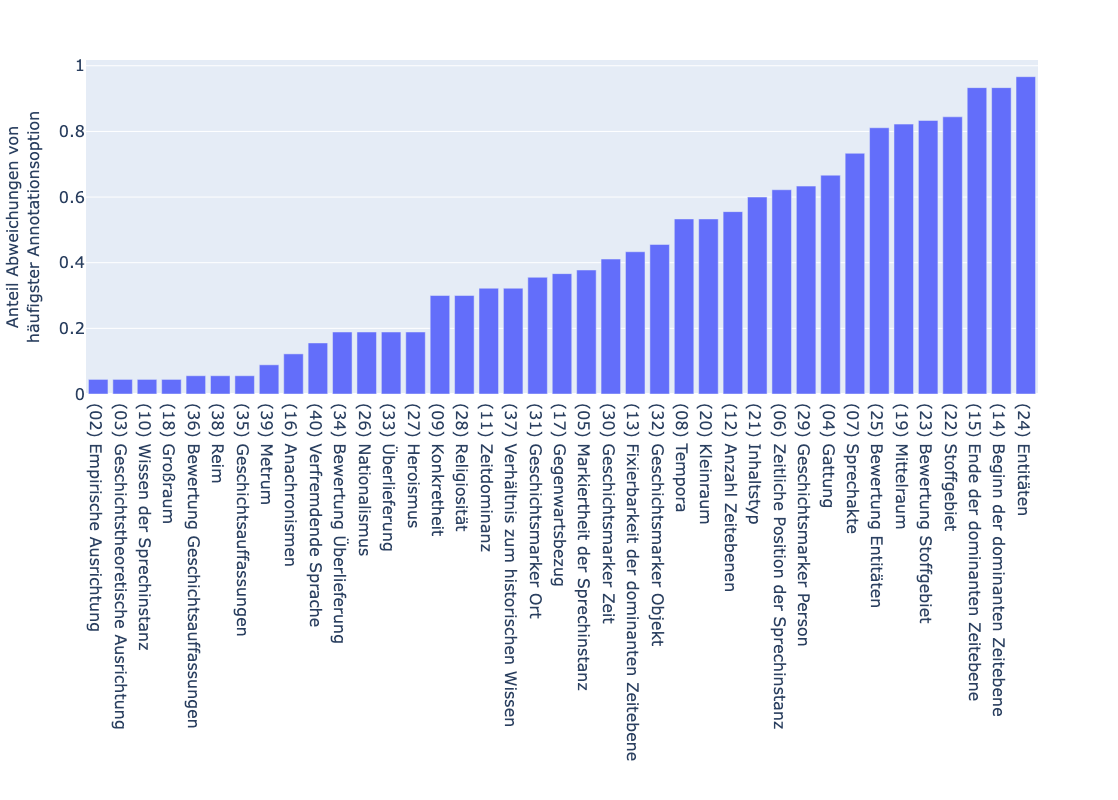

In [34]:
fig = px.bar(
    iaa_overview.sort_values(by = 'div_from_top_rel'),
    y = 'div_from_top_rel',
    labels = {
        'div_from_top_rel': "Anteil Abweichungen von<br>häufigster Annotationsoption",
        'variable' : '',
    }
)

fig.update_layout(
    height=800,
    xaxis=dict(title='',tickfont=dict(size=16), titlefont=dict(size=16)),
    yaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
)

fig.show()

In [35]:
meta_all = annotations.query("author_title.isin(@ak_ek_mk_texts)")

for category in ['(10) Wissen der Sprechinstanz', '(35) Geschichtsauffassungen']:
    print("\n")
    print(category)
    
    for annotator in ['ak', 'ek', 'mk']:
        value_counts = meta_all.query("annotator == @annotator")[category].value_counts(dropna=False)
        divs = sum(value_counts) - value_counts.iloc[0]
        
        print(f"{annotator} – {divs}x nicht Default-Annotation")



(10) Wissen der Sprechinstanz
ak – 2x nicht Default-Annotation
ek – 2x nicht Default-Annotation
mk – 0x nicht Default-Annotation


(35) Geschichtsauffassungen
ak – 0x nicht Default-Annotation
ek – 2x nicht Default-Annotation
mk – 3x nicht Default-Annotation


In [36]:
# nur Kategorien einbeziehen, bei denen min. X mal etwas 
# anderes als die häufigste Kategorie annotiert wurde

min_div_from_top_abs = 5

In [37]:
exclude_categories = iaa_overview.query("div_from_top_abs < @min_div_from_top_abs").index.tolist()

print(len(exclude_categories))

exclude_categories

10


['(02) Empirische Ausrichtung',
 '(03) Geschichtstheoretische Ausrichtung',
 '(10) Wissen der Sprechinstanz',
 '(16) Anachronismen',
 '(18) Großraum',
 '(35) Geschichtsauffassungen',
 '(36) Bewertung Geschichtsauffassungen',
 '(38) Reim',
 '(39) Metrum',
 '(40) Verfremdende Sprache']

In [38]:
meta_plot = iaa_overview.drop(exclude_categories).copy()

meta_plot = meta_plot.rename(columns={
    'ak_ek' : 'SHK1<>SHK2',
    'ak_mk' : 'SHK1<>Verfasser',
    'ek_mk' : 'SHK2<>Verfasser',
    'ak_ek_mk' : 'SHK1<>SHK2<>Verfasser'
})

fig = px.box(
    meta_plot,
    y = ['SHK1<>SHK2', 'SHK1<>Verfasser', 'SHK2<>Verfasser', 'SHK1<>SHK2<>Verfasser'],
    points = 'all',
    hover_data = [meta_plot.index],
    labels = {
        'value': "Agreement (Krippendorff's alpha)",
        'variable' : '',
    }
)

fig.update_layout(
    width = 1000, height = 500,
    xaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
    yaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
)
fig.show()